# 오토인코더 결합을 통한 이미지 분류모델 성능 개선에 대한 분석
## : 가위, 바위, 보 분류모델을 중심으로
***
<br>

#### 국문초록
<hr>
<span style="font-size:11pt; line-height:1.5;">
    &nbsp; &nbsp; 오토인코더를 일반적인 이미지 분류 모델에 결합하는 것에 대한 성능 개선 여부를 판단하기위해 일반적인 이미지 분류 모델과 오토인코더를 결합한 모델을 비교하였다. 학습데이터는 인터넷과 서적, Aiffel 학생들이 공유한 데이터셋을 사용하였으며, 테스트는 SGD와 Adam 옵티마이저 별 10 Epochs 동안의 test 데이터에 대한 오류와 정확도를 기록하였다. 분석 결과 SGD에서의 일반적인 모델과 오토인코더를 결합한 모델의 '오차'와 '정확도'에는 유의미한 차이가 없었다. Adam에서의 일반적인 모델과 오토인코더를 결합한 모델의 '오차'는 0.003으로 큰 차이가 없었다. 정확도의 경우 각 모델의 '10 Epochs 중 최고 정확도'와 '10 Epochs 전체 정확도의 평균' 모두 오토인코더를 결합한 모델의 정확도가 1% 높은 것을 확인하였다.
</span>
<hr>

### 1. 서론
***
<!-- 공백: &nbsp; <pre> -->
<!-- 글꼴: Hanna, Jeju Gothic, Nanum Gothic, Serif -->

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 최근 인공 신경망(이하 ANN) 연구에서 주목 받고 있는 주제는 '모델의 효율성 개선'이라 할 수 있다. 현재의 ANN은 이미지 분류에 있어 그 정확도가 인간을 넘어섰다(인간의 인식 오류는 5%이며, 2015년 제시된 'ResNet'의 인식 오류는 3.6%). 하지만 모델의 정확도 개선과 함께 파라미터의 크기도 상대적으로 증가하여, 모델 학습에 상당한 시간이 소요되는 문제가 존재한다. [표 1]은 '지능형인프라기술연구단'에서 제시한 모델의 정확도와 학습시간 증가 정도를 보여준다[1]. 이는 곧, 모델의 정확도 증가를 위해서는 깊은 모델이 요구되기 때문에 결국 학습 시간이 증가하는 것이라 할 수 있다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 따라서 최근의 연구는 이러한 '효율성' 문제를 개선하기 위해, <b>'동일 시간 내에 더 빠르게 정확도에 수렴하는 모델 고안', '적은 학습 데이터로 모델을 학습 하는 방안', '모델의 아키텍처를 최적화 하는 방안'</b> 등의 방법론을 중심으로 이루어지고 있다. 특히 적은 학습 데이터로 모델을 그대로 학습 할 때 발생하는 '과적합'과 같은 문제를 해결하기 위해 '자기지도학습(Self-Supervised Learning)', 이미지 보강, 드롭아웃(Drop-out) 등의 기법이 제시되었다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 이에 본 분석은 분류 모델과 오토인코더 모델의 결합을 통한 모델의 효율성 개선에 대해 분석하고자 한다. 또한, 자체적으로 수집한 데이터셋과 외부 데이터셋을 이용하여 '가위, 바위, 보' 이미지 분류 모델을 토대로 분석을 진행한다.
</span><br><br>

<br></br>
<br></br>

||Error Rate(%)|Train Time(days)|
|:--------:|:--------:|:--------:|
|**ResNet18**|10.76|2.5|
|**ResNet50**|7.02|5|
|**ResNet101**|6.21|7|
|**ResNet152**|6.16|10.5|

<center>[표 1] 모델의 정확도와 학습시간 증가</center>


***

### 2. 이론적 배경
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 오토인코더를 결합한 이미지 분류 모델이란, 하나의 신경망으로부터 '디코더'와 '분류', 이 두 개의 출력이 이루어지는 모델을 의미한다. 일반적인 이미지 분류 모델 같은 경우, Convolution 레이어 이후 평탄화(flat) 작업과 밀집 계층을 통해 softmax로 출력되는 형태가 대부분이다. 본 분석에서는 이러한 일반적인 이미지 분류 모델에 디코더를 추가하여, 모델의 성능 개선 여부에 대해 분석하고자 한다. 
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 두 개의 출력을 갖는 단일 신경망은 이미 다양한 모델에 적용된 바 있다. 특히, 딥마인드에서 2017년 발표한 알파고 제로(AlphaGo zero, AGZ)가 이에 해당한다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 두 개의 모델을 통해 각각의 출력을 받을 수도 있지만, 하나의 모델이 두 개의 출력을 가지게 하는 것을 통해 얻을 수 있는 이점이 존재한다. 각각의 출력은 서로 다른 출력의 표준화된 형태이다. 즉, 두 출력값은 가위, 바위, 보 이미지로부터 연관이 있기에 서로 영향을 미치게 된다. 따라서, 두 출력값을 동시에 학습 시키는 것으로 신경망이 적합한 표현형을 학습한다. 이러한 내용을 바탕으로 두 개의 출력을 가지는 단일 신경망은 '일반화 능력의 향상'과 '훈련 속도 단축', '과적합 방지'를 도모할 수 있게 된다[4].
</span>

***

### 3. 분석방법
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 본 분석은 '일반적인 분류 모델'과 '오토인코더를 결합한 분류 모델'의 오차와 정확도를 비교하여 모델의 성능 개선 여부를 판단 한다. 모델 학습에 이용된 데이터셋의 경우 인터넷에 공개된 자료와 Aiffel에서 제공받은 가위, 바위, 보 이미지를 활용하며, 데이터셋은 Min-Max 정규화와 회전, 노이즈 추가 등의 통해 전처리를 진행한다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 각각의 모델은 디코더 부분을 제외하고 상호 동일하게 설계한다. 모델 간의 비교를 위해 '확률적 경사 하강법'과 'Adam', 두 옵티마이저에서 10epochs 동안 test 데이터의 '오차'와 '정확도'를 추적·비교하여 성능 개선 여부를 판단하고자 한다.
</span>

***

#### [학습 데이터 정보]
***

> <b>공통 정보</b><br>
> + image_size: 96 * 96 * 1(gray)

<br>

> <b>내부 데이터셋</b>
> + <b>dataset_own.zip</b>
>    + train 각 100장(총 300장)
>    
> 
> + <b>dataset_lms.zip</b>
>    + train 각 640장(총 1,920장)
>    + test 각 120장(총 360장)

<br>

> <b>외부 데이터셋</b>
> + <b>dataset.zip</b>
>    + train 각 840장(총 2,520장)
>    + test 각 124장(총 372장)
>    
> 
> + <b>dataset_sec.zip</b>
>    + train 각 1288장(총 3,864장)
>    + test 각 322장(총 966장)
***

***
#### 내부(Aiffel) 데이터셋 출처
+ "dataset_own.zip"은 본 분석의 분석자가 직접 생성한 이미지 데이터 셋이다.
+ "dataset_lms.zip"은 Aiffel 분들과 'LMS기본 제공'의 데이터를 총합하여 재구성 하였다.

<br>

#### 외부 데이터셋 출처
+ "dataset.zip"은 "Laurence Moroney"에서 제공하는 데이터셋[1]을 전처리(흑백 변환, 사이즈 변경)하여 재구성 하였다.
+ "dataset_sec.zip"은 『머신러닝 부트캠프 with 파이썬』 서적에서 제공하는 '이미지를 사용한 손 모양 분류' 데이터셋[2]을 전처리(흑백 변환, 사이즈 변경, 데이터 분류)하여 재구성 하였다.
***

#### 패키지 호출 및 데이터셋 압축 해제

In [1]:
import os   #시스템 디렉토리 관리
import zipfile   #dataset 압축 관리
import cv2   #이미지 저장 및 전처리
import numpy as np   #배열 작업
import matplotlib.pyplot as plt   #시각화 처리
import tensorflow as tf   #행렬 및 모델 생성

In [2]:
#dataset.zip파일 압축 해제
def unzip(data_dir):
    if not os.path.isdir("." + data_dir.split(".")[1]):
        if os.path.isfile(data_dir):
            zip = zipfile.ZipFile(data_dir)   #압축 파일 읽기
            zip.extractall("./dataset/")   #압축 해제
            print("done.....")
        else:
            print("has no zip file")
        pass
    else:
        print("already has dataset")

unzip("./dataset/dataset.zip")
unzip("./dataset/dataset_sec.zip")
unzip("./dataset/dataset_own.zip")   #자체적으로 생성한 데이터셋
unzip("./dataset/dataset_lms.zip")   #'Aiffel 및 'LMS기본 제공'

already has dataset
already has dataset
already has dataset
already has dataset


### 3. 데이터 전처리
***
#### 3.1 이미지 크기 설정<br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 가위, 바위, 보 분류는 손의 실루엣을 바탕으로 클래스를 분류하게 된다. MNIST와 같은 경우 숫자의 패턴이 단순하고 배경과 확실하게 분류되어 있는 반면, 가위, 바위, 보 이미지 같은 경우 그 패턴이 다앙하며, 손과 배경의 경계가 모호하다. 나아가, 자체적으로 수집한 데이터는 다양한 인원들로부터 촬영된 이미지로 그 특징이 다양할 양상이 크다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 따라서 MNIST에서 흔히 사용되는 28 * 28의 입력 크기를 가위, 바위, 보 분류 모델에 적용하기보다는 모델이 어느정도 이미지로부터 손의 실루엣을 검출할 수 있는 적당한 사이즈로 입력할 필요가 있다. 이러한 이유를 바탕으로 본 분석에서는 이미지의 크기를 96 * 96으로 재조정하였다.
</span><br><br>


#### 3.2 오토인코더를 고려한 이미지 크기 설정<br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 오토인코더를 사용한다면 입력 데이터의 크기를 신경쓸 필요가 있다. 레이어 출력의 크기를 줄이기 위해 Pooling 레이어를 사용하는데 중간에 홀수 크기의 레이어가 존재할 시, 정확하게 절반으로 나눌 수 없기 때문에 의도치 않은 크기로 변형된다(Pooling 크기가 2 * 2라는 전제에서). 즉 9 * 9 크기의 Convolution 레이어 이후에 Pooling 레이어가 있다면, 4.5 * 4.5가 아닌 4 * 4의 크기가 된다. 이를 다시 복호화 하기위해 UpSampling을 한다면 8 * 8의 크기가 된다. 출력과 입력의 크기가 다른 것이다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 물론, 오토인코더의 입력 데이터 크기와 출력 데이터의 크기가 반드시 같을 필요는 없다. 하지만 크기가 다를 경우 오토인코더의 입력 데이터를 바로 target 데이터로써 활용 할 수 없고 재차 이미지의 크기를 변경해야한다. 따라서 본 분석에서는 세 번의 Pooling 레이어가 존재하여 입력 사이즈를 $2^3$의 배수인 96 * 96으로 설정하였다.
</span><br><br>


#### 3.3 한 개의 채널만 사용<br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 가위, 바위, 보 분류는 손의 실루엣을 판별하는 문제로 반드시 RGB 3채널을 모두 사용할 필요가 없다. 피부의 색을 통해 '손'이라는 패턴을 인식 할 수도 있겠지만, 앞서 설명한 바와 같이 역광에서는 색을 통해 인식하기 어렵다. 또한, 3개의 채널을 활용할 시에는 96 * 96 * 3으로 27,648개의 퍼셉트론이 연산에 이용되지만, 한 개의 채널을 활용할 때는 9,216개만이 이용된다. 즉 약소하지만 모델의 경량화가 가능하다. 따라서 본 분석에서는 세 개의 채널을 한 개의 채널로 변환하는 과정에서 이루어지는 정보의 손실을 감수하고 모델의 경량화를 위해 최종적으로 gray 한 개의 채널인 96 * 96 * 1로 이미지를 전처리 하였다.
</span><br><br>

***

In [3]:
#이미지 데이터 받아오기
def get_data(dir):
    img_list = os.listdir(dir)
    return_list = []
    for img_name in img_list:
        
        add_img = cv2.imread(dir + img_name, cv2.IMREAD_GRAYSCALE)   #read to gray
        add_img = cv2.resize(add_img, dsize=(96, 96))   #resize
        add_img = np.array(add_img / 255, dtype=np.float32)   #min-max normalize
        
        return_list.append(add_img)    #각 반환 리스트에 저장
            
    return np.array(return_list, dtype=np.float32)   #list => numpy 변환

#이미지 호출
train_rock = np.concatenate((get_data("./dataset/dataset/train/rock/"), get_data("./dataset/dataset_sec/train/rock/")))
train_rock = np.concatenate((train_rock, get_data("./dataset/dataset_own/rock/"), get_data("./dataset/dataset_lms/train/rock/")))

train_scissors = np.concatenate((get_data("./dataset/dataset/train/scissors/"), get_data("./dataset/dataset_sec/train/scissors/")))
train_scissors = np.concatenate((train_scissors, get_data("./dataset/dataset_own/scissors/"), get_data("./dataset/dataset_lms/train/scissors/")))

train_paper = np.concatenate((get_data("./dataset/dataset/train/paper/"), get_data("./dataset/dataset_sec/train/paper/")))
train_paper = np.concatenate((train_paper, get_data("./dataset/dataset_own/paper/"), get_data("./dataset/dataset_lms/train/paper/")))

print("done......")

done......


#### 데이터셋 시각화

**************************************************
rock_data size: (2868, 96, 96)
scissors_data size: (2868, 96, 96)
paper_data size: (2868, 96, 96)
**************************************************


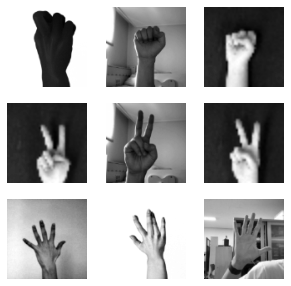

In [4]:
#학습 데이터 시각화
print("*" * 50)
print("rock_data size: " + str(train_rock.shape))
print("scissors_data size: " + str(train_scissors.shape))
print("paper_data size: " + str(train_paper.shape))
print("*" * 50)

plt.figure(figsize=(5, 5))
for class_idx, vari in enumerate([train_rock, train_scissors, train_paper]):
    rand_idx = np.random.choice(len(train_rock), size=3, replace=False)
    for same_idx, img_idx in enumerate(rand_idx):
        plt.subplot(3, 3, 3 * class_idx + same_idx + 1)
        plt.imshow(vari[img_idx], cmap="gray")
        plt.axis("off")
  

### 4. 이미지 보강
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 적은 수의 데이터로 딥러닝 모델을 학습시킬 경우 '과적합'의 우려가 있다. '이미지 보강(ImageDataGenerator)' 기법은 이미지의 회전, 확대 및 축소, 이동을 통해 학습 데이터 수를 늘려주어 과적합을 방지하여 준다. 본 분석에서는 이미지의 회전, 확대, 기울이기, 좌우 대칭 뒤집기, 노이즈 추가 등의 변형을 통한 이미지 보강을 실시하였다. 실시한 이미지 보강의 구체적인 순서는 다음과 같다.
</span><br><br>


> 1. 원본 데이터의 $\frac{1}{2}$을 비복원 추출한다.<br><br>
> 2. 추출한 데이터를 랜덤하게 회전, 확대, 기울이기, 이동, 좌우대칭 뒤집기를 통해 변형한다.<br><br>
> 3. 기존 원본 데이터와 변형 데이터를 결합한다.<br><br>
> 4. 결합한 데이터 중 다시 $\frac{1}{2}$을 비복원 추출한다.<br><br>
> 5. 추출한 데이터에 '가우시안 노이즈'를 입힌다.<br><br>
> 6. 이를 다시 데이터에 결합한다.<br><br>

<br>최종적인 데이터는 다음과 같다.<br>
<b>(원본 데이터 + 회전, 확대, 기울이기 등의 데이터 + 노이즈 데이터)</b>

***

#### 4.1 이미지 보강: 확대, 회전, 좌우대칭 뒤집기

In [5]:
#이미지 보강
#1. 이미지 확대, 회전, 반전
#텐서플로2.0 프로그래밍 p.166
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def augment_image(input_data):
    image_generator = ImageDataGenerator(
        rotation_range=60,
        zoom_range=0.05,
        shear_range=0.5,
        width_shift_range=0.10,
        height_shift_range=0.10,
        horizontal_flip=True,
        vertical_flip=False
    )

    new_data_size = int(len(input_data) / 2)
    rand_idx = np.random.choice(new_data_size, size=new_data_size, replace=False)

    new_data = input_data[rand_idx].copy()
    new_data = image_generator.flow(
        new_data.reshape(-1, 96, 96, 1), np.zeros(new_data_size), batch_size=new_data_size, shuffle=False
    ).next()[0]
    return new_data.reshape(new_data_size, 96, 96)

train_rock = np.concatenate((train_rock, augment_image(train_rock)))
train_scissors = np.concatenate((train_scissors, augment_image(train_scissors)))
train_paper = np.concatenate((train_paper, augment_image(train_paper)))

#### 4.2 이미지 보강: 가우시안 노이즈

In [6]:
#이미지 보강
#2. 데이터 가우시안 노이즈 추가
#실전 딥러닝 p.173
def noise_data(input_data):
    new_data_size = int(len(input_data) / 2)
    rand_idx = np.random.choice(new_data_size, size=new_data_size, replace=False)
    origin_data = input_data[rand_idx].copy()
    new_data = input_data[rand_idx].copy()
    
    for data in new_data:
        data += np.random.normal(loc=0, scale=0.06, size=data.shape)
        data = np.clip(data, 0, 1)
    return [new_data, origin_data]

noise_train_rock, noise_target_rock = noise_data(train_rock)
noise_train_scissors, noise_target_scissors = noise_data(train_scissors)
noise_train_paper, noise_target_paper = noise_data(train_paper)

***
#### 이미지 보강 참고 문헌
+ 이미지 확대, 회전, 반전 등의 이미지 보강 방법은 『시작하세요! 텐서플로 2.0 프로그래밍』 서적을 참고 하였다[2].
+ 데이터 노이즈 추가 방법은 『실전! 딥러닝』 서적을 참고 하였다[3].
***

#### 배열 크기 및 target 데이터 생성 등의 전처리
***
+ 하나의 신경망에서 이미지 복원과 분류 softmax, 두 개의 출력이 존재하므로 target 데이터 또한 각각 준비한다.
***

In [7]:
#데이터 전처리
#1. 배열 입력 사이즈 수정
#2. target 데이터 생성

#v2: autoincoder이므로 target_data = train_data
#v3: [autoencoder, softmax]

target_rock = np.concatenate((train_rock, noise_target_rock))
target_scissors = np.concatenate((train_scissors, noise_target_scissors))
target_paper = np.concatenate((train_paper, noise_target_paper))
auto_target_data = np.concatenate((target_rock, target_scissors, target_paper)).reshape(-1, 96, 96, 1)

value_target_rock = [[1, 0, 0]] * len(target_rock)
value_target_scissors = [[0, 1, 0]] * len(target_scissors)
value_target_paper = [[0, 0, 1]] * len(target_paper)
value_target_data = np.concatenate((value_target_rock, value_target_scissors, value_target_paper))

train_rock = np.concatenate((train_rock, noise_train_rock))
train_scissors = np.concatenate((train_scissors, noise_train_scissors))
train_paper = np.concatenate((train_paper, noise_train_paper))

train_data = np.concatenate((train_rock, train_scissors, train_paper)).reshape(-1, 96, 96, 1)

#### 이미지 보강을 추가한 최종 학습 데이터 시각화
***
+ 몇몇 데이터로부터 노이즈가 추가된 것과 회전된 이미지를 확인할 수 있다.
***

**************************************************
train_data size: (19359, 96, 96, 1)
**************************************************


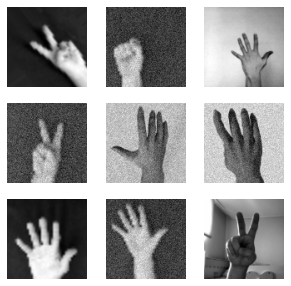

In [8]:
#학습 데이터 시각화
print("*" * 50)
print("train_data size: " + str(train_data.shape))
print("*" * 50)

rand_idx = np.random.choice(len(train_data), size=9, replace=False)
plt.figure(figsize=(5, 5))

for i, img_idx in enumerate(rand_idx):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.imshow(train_data[img_idx], cmap="gray")

### 5. 모델 아키텍처 설계
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 오토인코더를 결합한 분류모델의 성능 개선 여부를 판단하기 위해, 일반적인 분류모델과 비교하고자 한다. 따라서 모델의 아키텍처는 디코더 부분을 제외한 입, softmax 출력 레이어는 동일하게 설계하였다. 일반적인 분류모델은 'Alpha Net'으로 명명하고 오토인코더를 결합한 분류모델은 'Beta Net'으로 명명한다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; Alpha Net과 Beta Net에서 동일한 모델의 상단 부분(인코더 혹은 입력에서 flat 레이어까지)은 VGG모델에서 차용한 '몇 개의 Convolution 레이어 층 이후 2 *2 Max Pooling 레이어로 크기를 줄이고 fillter의 개수는 점차 배수로 늘리는 방법'을 토대로 설계하였다. 본 분석에서 차용한 분류 모델은 한 개의 Convolution 레이어와 Max Pooling 레이어를 순차적으로 두 차례 반복하고 마지막에는 256개의 필터를 이용하는 Convolution 레이어를 추가하였다. 따라서 Convolution 레이어는 총 세 개로, fillter의 개수는 순차적으로 64개, 128개, 256개이다. kernel 크기는 3 * 3으로 설정하였다. 또한, Max Pooling 이후에는 과적합을 방지하기 위해 30% 비율로 드롭아웃을 실시하였다. 활성화 함수로는 'RELU'를 사용하였다. 
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; Dense 층 이전, Convolution 출력층의 크기를 줄이기 위해 4 * 4 크기의 Maxpooling 레이어를 추가하였다. 이후 64개의 퍼셉트론을 이용한 Dense 층을 추가하였으며 활성화 함수로는 'Leaky RELU'를 사용, 50% 비율로 드롭아웃을 실시하였다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; Beta net에서는 입력과 동일한 출력을 목표로 하는 디코더 부분을 결합하였다. 오토인코더에서 사용된 Convolution 레이어와 Max Pooling 레이어를 반대로 추가하여 입력의 크기(96 * 96 * 1)와 동일하게 출력되도록 하였다.
</span><br><br>

***

#### 5.1 Alpha Net 설계

In [10]:
def get_alpha_net():
    alpha_net = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, input_shape=(96, 96, 1), activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(rate=0.3),

        tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=128, activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(rate=0.3),

        tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=256, activation="relu", padding="same"),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.MaxPool2D(pool_size=(4, 4)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=64, activation=tf.keras.layers.LeakyReLU()),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(3, activation="softmax", name="value")
    ], name="alpha")
    return alpha_net

alpha_net = get_alpha_net()
alpha_net.summary()
tf.keras.utils.plot_model(alpha_net, show_shapes = True) # model 구조 그림으로 표현
alpha_net = None

Model: "alpha"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 256)       295168

#### 5.2 Beta Net 설계

In [10]:
def get_beta_net():
    #Encoder...........................................
    input = tf.keras.layers.Input(shape=(96, 96, 1))

    conv1_1 = tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation="relu", padding="same")(input)
    maxP1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv1_1)
    dropout1 = tf.keras.layers.Dropout(rate=0.3)(maxP1)

    conv2_1 = tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=128, activation="relu", padding="same")(dropout1)
    maxP2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2_1)
    dropout2 = tf.keras.layers.Dropout(rate=0.3)(maxP2)

    conv3_1 = tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=256, activation="relu", padding="same")(dropout2)
    dropout3 = tf.keras.layers.Dropout(rate=0.3)(conv3_1)
    #End...................................................

    #Decoder...........................................
    dec_conv1 = tf.keras.layers.Conv2DTranspose(
        kernel_size=(3, 3), filters=256, activation=tf.keras.layers.LeakyReLU(), padding='same'
    )(dropout3)
    dec_upSamp1 = tf.keras.layers.UpSampling2D((2, 2))(dec_conv1)

    dec_conv2 = tf.keras.layers.Conv2DTranspose(
        kernel_size=(3, 3), filters=128, activation=tf.keras.layers.LeakyReLU(), padding='same'
    )(dec_upSamp1)
    dec_upSamp2 = tf.keras.layers.UpSampling2D((2, 2))(dec_conv2)

    dec_output = tf.keras.layers.Conv2D(
        kernel_size=(3, 3), filters=1, activation="sigmoid", padding='same', name="dec"
    )(dec_upSamp2)
    #End...................................................

    #Value.................................................
    maxP4 = tf.keras.layers.MaxPool2D(pool_size=(4, 4))(dropout3)
    flat1 = tf.keras.layers.Flatten()(maxP4)
    value_dense1 = tf.keras.layers.Dense(units=64, activation=tf.keras.layers.LeakyReLU())(flat1)
    value_dropout1 = tf.keras.layers.Dropout(rate=0.5)(value_dense1)
    value_output = tf.keras.layers.Dense(3, activation="softmax", name="value")(value_dropout1)

    #End...................................................

    beta_net = tf.keras.models.Model(inputs=input, outputs=[dec_output, value_output], name="beta")
    return beta_net

beta_net = get_beta_net()
beta_net.summary()
beta_net = None

Model: "beta"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 96, 96, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 48, 48, 64)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 48, 48, 64)   0           max_pooling2d_3[0][0]            
_______________________________________________________________________________________________

#### 5.3 학습 옵티마이저 및 하이퍼파라이터 설정
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 테스트는 모델의 학습에 주로 이용되는 '확률적 경사 하강법'과 'Adam' 옵티마이저를 대상으로 진행한다. 두 모델 모두 공통적으로 배치사이즈는 16으로 설정하였으며, 검증 데이터는 학습 데이터로부터 20%를 추출하여 사용한다. 또한 학습 데이터 구성시 바위, 가위, 보 순으로 누적하였기 때문에 모델을 무작위로 섞어 학습을 진행한다. 또한, Beta Net의 경우 디코더 출력부와 분류 출력부에 각각 0.1과 1.0의 비율로 loss weight를 설정하였다.
</span>

***

#### 콜백, 모델 컴파일, 학습 함수
***
+ 콜백 함수: 매 epoch마다 테스트 데이터를 평가하여 '오류'와 '정확도'를 기록한다.
<br>
<span style="font-size:10pt;">* 분석을 위해 사용하였으며, Jupyter 상에서는 사용하지 않음</span>
***

In [11]:
class EpochCallback(tf.keras.callbacks.Callback):   #callback
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.previous_loss = None
        self.callback_loss, self.callback_acc = [], []

    def on_epoch_end(self, epoch, logs=None):
        print("\nwait for callback" + "*" * 80)
        if self.name == "alpha":   #alpha net
            loss, acc = alpha_net.evaluate(test_data, test_value_target_data)
        elif self.name == "beta":   #beta_net
            _, _, loss, _, acc = beta_net.evaluate(test_data, [test_auto_target_data, test_value_target_data])
        self.callback_loss += [loss]   
        self.callback_acc += [acc]
        print("done" + "*" * 93, end="\n\n")

def regist_compile(net):
    net.compile(   #compile
        metrics=["accuracy"],
        optimizer = tf.keras.optimizers.Adam(),
        loss = ["binary_crossentropy", "categorical_crossentropy"],
        loss_weights = [0.1, 1.]
    )

### 6. 분석 결과
***

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 옵티마이저 별 차이를 확인하기 위해 '확률적 경사 하강법'과 'Adam'에 대해 테스트를 진행하였다. 10epochs 동안의 test 데이터에 대한 '정확도'와 '오차'를 기록하였다. 또한, 각 모델의 가중치는 초기화 시에 새롭게 바뀌기 때문에 매번 그 결과가 다를 수 있다. 이를 고려하여, 최초 1회만 기록하지 않고 총 5회 테스트를 진행하여 그 평균을 이용하였다. 즉, [표 2]의 1Epochs 일때, Loss인 0.845는 Alpha Net을 SGD에서 총 5회 테스트 한 후, 그 평균을 구한 것에 해당한다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; [표 2]와 [표 3]은 Alpha Net과 Beta Net의 learning late 0.01에서 '확률적 경사 하강법'을 이용하였을 때의 테스트 데이터에 대한 '오차'와 '정확도'를 보여준다. 오차의 경우 Beta Net의 최저 오차가 0.395로 Alpha Net의 0.391에 비해 0.004 높은 수준으로 큰 차이가 없음을 확인하였다. 전체 평균 오차또한 Beta Net이 0.002 높은 것을 확인하였다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 정확도의 경우 Beta Net의 최고 정확도가 83.8%로 Alpha Net의 83.5%에 비해 0.3% 높은 수준으로 큰 차이가 없음을 확인하였다. 전체 Epochs에 대한 정확도의 평균은 Beta Net이 79.9%로 Alpha Net의 79.8%와 큰차이 없음을 확인하였다.
</span><br><br><br>

|Epochs|1|2|3|4|5|6|7|8|9|10|mean|
|:--------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|**Loss**|0.845|0.658|0.528|0.456|0.428|0.412|0.416|0.412|0.404|<b style="color:red">0.391</b>|0.495|
|**Accuracy**|0.678|0.748|0.785|0.797|0.818|0.827|0.828|0.832|<b style="color:red">0.835</b>|0.835|0.798|

<center>[표 2] Alpha Net SGD(learning late: 0.01) loss & accuracy</center>

<br></br>

|Epochs|1|2|3|4|5|6|7|8|9|10|mean|
|:--------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|**Loss**|0.831|0.657|0.54|0.467|0.435|0.412|0.419|<b style="color:red">0.395</b>|0.413|0.399|0.497|
|**Accuracy**|0.696|0.742|0.779|0.791|0.821|0.834|0.828|0.836|0.828|<b style="color:red">0.838</b>|0.799|

<center>[표 3] Beta Net SGD(learning late: 0.01) loss & accuracy</center>

<br></br><br></br><br></br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; [표 4]와 [표 5]는 Alpha Net과 Beta Net의 Adam 옵티마이저를 이용하였을 경우, 테스트 데이터에 대한 '오차'와 '정확도'를 보여준다. 오차의 경우 Beta Net의 최저 오차가 0.29로 Alpha Net의 0.287에 비해 0.003 높은 수준으로 큰 차이가 없음을 확인하였다. 전체 평균 오차는 Beta Net이 0.361로 Alpha Net에 비해 0.017 감소하여 소폭 감소 한 것을 확인하였다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 정확도의 경우 Beta Net의 최고 정확도가 91.6%로 Alpha Net의 90.6%에 비해 1.0% 소폭 상승 한 것을 확인 하였다. 전체 Epochs에 대한 정확도의 평균 또한, Beta Net이 89.4%로 Alpha Net의 88.5%에 비해 1.0% 소폭 상승 한 것을 확인하였다.
</span><br><br><br>

|Epochs|1|2|3|4|5|6|7|8|9|10|mean|
|:--------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|**Loss**|0.433|0.429|0.3|<b style="color:red">0.287</b>|0.329|0.355|0.337|0.443|0.391|0.479|0.378|
|**Accuracy**|0.819|0.839|0.892|0.904|0.896|0.897|0.904|0.89|<b style="color:red">0.906</b>|0.904|0.885|

<center>[표 4] Alpha Net Adam loss & accuracy</center>

<br></br>

|Epochs|1|2|3|4|5|6|7|8|9|10|mean|
|:--------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|**Loss**|0.376|0.32|<b style="color:red">0.29</b>|0.295|0.378|0.365|0.403|0.366|0.37|0.451|0.361|
|**Accuracy**|0.845|0.875|0.897|0.901|0.883|0.904|0.9|0.909|<b style="color:red">0.916</b>|0.906|0.894|

<center>[표 5] Beta Net Adam loss & accuracy</center>

<br></br><br></br><br></br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 결론적으로, 오토인코더를 결합한 분류 모델과 일반적인 분류 모델은 learning late 0.01에서 확률적 경사 하강법을 사용하였을 때, 유의미한 차이가 없다 고 할 수 있다. 그러나, Adam을 사용하였을 경우, 그 차이가 확률적 경사 하강법에 비해 크게 나타난다. 10 Epochs 중 가장 최저 오차는 일반적인 모델이 낮게 나왔지만, 전체 Epochs의 오차 평균은 오토인코더를 결합한 모델이 미미하게 낮았다. 또한, 정확도의 경우 오토인코더를 결합한 모델의 최고 정확도가 1% 높았으며, 전체 Epochs의 정확도 평균 또한 1% 높았다.
</span>

***

#### Beta Net 학습 및 예측 결과
***
+ 사전에 Alpha Net과 Beta Net 모델의 학습, 예측이 이루어졌기에 그 결과만 확인할 수 있었다. 따라서, 예시로 Beta Net의 학습 과정과 예측 결과를 제시한다.
***

In [12]:
beta_net = get_beta_net()
beta_net.compile(   #compile
    metrics=["accuracy"],
    optimizer = tf.keras.optimizers.Adam(),
    loss = ["binary_crossentropy", "categorical_crossentropy"],
    loss_weights = [0.1, 1.]
)

beta_net.fit(
    x=train_data,
    y=[auto_target_data, value_target_data],
    batch_size=16,
    epochs=10,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/10
968/968 [==============================] - 104s 91ms/step - loss: 0.6766 - dec_loss: 0.4871 - value_loss: 0.6279 - dec_accuracy: 0.0679 - value_accuracy: 0.7064 - val_loss: 1.1784 - val_dec_loss: 0.4279 - val_value_loss: 1.1356 - val_dec_accuracy: 0.1248 - val_value_accuracy: 0.7105
Epoch 2/10
968/968 [==============================] - 73s 76ms/step - loss: 0.1903 - dec_loss: 0.4501 - value_loss: 0.1453 - dec_accuracy: 0.0674 - value_accuracy: 0.9452 - val_loss: 1.4676 - val_dec_loss: 0.4216 - val_value_loss: 1.4255 - val_dec_accuracy: 0.1248 - val_value_accuracy: 0.7433
Epoch 3/10
968/968 [==============================] - 73s 76ms/step - loss: 0.1321 - dec_loss: 0.4384 - value_loss: 0.0882 - dec_accuracy: 0.0669 - value_accuracy: 0.9679 - val_loss: 1.8450 - val_dec_loss: 0.4471 - val_value_loss: 1.8003 - val_dec_accuracy: 0.1248 - val_value_accuracy: 0.7670
Epoch 4/10
968/968 [==============================] - 73s 75ms/step - loss: 0.1158 - dec_loss: 0.4368 - value_loss: 0

#### 테스트 데이터 불러오기

In [13]:
#테스트 데이터 받아오기
test_rock = np.concatenate((get_data("./dataset/dataset/test/rock/"), get_data("./dataset/dataset_sec/test/rock/")))
test_rock = np.concatenate((test_rock, get_data("./dataset/dataset_lms/test/rock/")))

test_scissors = np.concatenate((get_data("./dataset/dataset/test/scissors/"), get_data("./dataset/dataset_sec/test/scissors/")))
test_scissors = np.concatenate((test_scissors, get_data("./dataset/dataset_lms/test/scissors/")))

test_paper = np.concatenate((get_data("./dataset/dataset/test/paper/"), get_data("./dataset/dataset_sec/test/paper/")))
test_paper = np.concatenate((test_paper, get_data("./dataset/dataset_lms/test/paper/")))

In [14]:
#데이터 전처리
#1. 배열 입력 사이즈 수정
#2. target 데이터 생성
test_data = np.concatenate((test_rock, test_scissors, test_paper)).reshape(-1, 96, 96, 1)

#value_target
test_value_rock = [[1, 0, 0]] * len(test_rock)
test_value_scissors = [[0, 1, 0]] * len(test_scissors)
test_value_paper = [[0, 0, 1]] * len(test_paper)
test_value_target_data = np.concatenate((test_value_rock, test_value_scissors, test_value_paper))

#auto_target
test_auto_target_data = test_data.copy()

#### Beta Net의 Test 데이터에 대한 오차와 정확도

In [15]:
_, _, value_loss, _, value_acc = beta_net.evaluate(test_data, [test_auto_target_data, test_value_target_data])

print("오차: " + str(value_loss))
print("정확도: " + str(value_acc))

57/57 [==============================] - 13s 117ms/step - loss: 0.4696 - dec_loss: 0.5227 - value_loss: 0.4174 - dec_accuracy: 3.4020e-06 - value_accuracy: 0.9098
오차: 0.4173694849014282
정확도: 0.9097909927368164


### 7. 결론
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 이미지 분류 모델에 오토인코더를 결합하였을 때, 성능 개선 여부를 판단하기위해 일반적인 모델과 오토인코더를 결합한 모델을 테스트하고 그 결과를 비교하였다. 그 결과, '확률적 경사 하강법'에서는 두 모델의 성능에 유의미한 차이가 없었다. 'Adam'을 이용할 경우 정확도가 약 1% 증가 한 것을 확인하였다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 오토인코더를 결합한 경우 디코더로 인해 모델의 파라미터가 일반적인 모델에 비해 많아지게 된다. 이는 연산의 증대로 이어지며, 학습 시간을 증가시키는 요인이 된다. 따라서 본 분석에서 이용한 학습데이터와 모델에 한하여 이야기 하였을 때, 1%의 정확도를 향상 시키기위해 오토인코더를 분류 모델과 결합 할 수 있지만, 그만큼 더 많은 연산을 필요로 하며 학습 시간이 증가할 수 있음을 인지할 필요가 있다. 
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 하지만, 오토인코더를 결합함으로써 얻게되는 다른 이점 또한 존재하는데, '약한 설명 가능한 모델'이라는 점이다. 현재의 인공 신경망의 큰 단점은 '그 내부를 들여다 볼 수 없는', 혹은 '해석 불가능한', 블랙박스의 형태라는 점이다. 하지만 오토인코더를 결합하는 것으로 모델이 인식하는 이미지의 형태를 재구성 한다는 점에서 신경망의 내부를 들여다 보는 것에 해당한다고 할 수 있다.
</span><br><br>

***

#### 디코더로 재구현한 입력 이미지

test0: 1.0, 0.0, 0.0
test1: 0.0, 1.0, 0.0
test2: 0.0, 0.0, 1.0


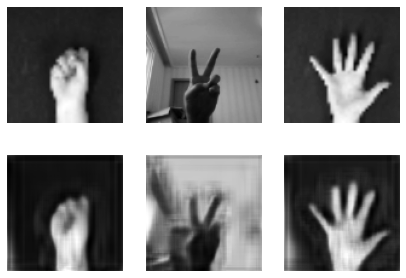

In [19]:
test1 = test_rock[np.random.choice(len(test_rock), size=1)].reshape(96, 96, 1)
test2 = test_scissors[np.random.choice(len(test_scissors), size=1)].reshape(96, 96, 1)
test3 = test_paper[np.random.choice(len(test_paper), size=1)].reshape(96, 96, 1)

test_list = np.array([test1, test2, test3])
dec, value = beta_net.predict(test_list)

plt.figure(figsize=(12, 5))

for idx, val in enumerate(value.round(2)):
    print("test" + str(idx) + ": " + str(val[0]) + ", " + str(val[1]) + ", " + str(val[2]))

for idx, image in enumerate(test_list):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 5, idx + 6)
    plt.imshow(dec[idx].reshape(96, 96, 1), cmap="gray")
    plt.axis("off")

### 참고자료 및 참고문헌
***
#### 참고문헌
[1] 지능형인프라기술연구단. (2020). 딥러닝 모델 경량화 기술 분석.

[2] 김환희, 『시작하세요! 텐서플로 2.0 프로그래밍』, 위키북스(2020), 166

[3] 오타 미쯔하사 외 3인, 『실전! 딥러닝』, 위키북스(2019), 173

[4] 막스 펌펄라 & 케빈 퍼거슨, 『Deep Learning and the Game of Go』, 한빛미디어(2020), 329-330

<br>

#### 외부 데이터셋
[1] "Datasets for Machine Learning", Laurence Moroney, last modified, , accessed Sep, 23, 2021, https://laurencemoroney.com/datasets.html

[2] 주식회사 시스템 계획 연구소, 『머신러닝 부트캠프 with 파이썬』, 길벗(2018), 128-162
***

### 형상관리 기록
***
+ <b>ver1</b>: convolution layer, Dense, softmax를 결합한 일반적 분류 모델 적용


+ <b>ver2</b>: 자기부호화 ANN 모델 적용


+ <b>ver3</b>: 자기부호화와 softmax 동시 출력 모델 적용
    + ver3_3: 이미지 size를 (96 * 96 * 1)로 resize하여, 파라미터 최소화, 데이터셋 추가
    
    
+ <b>ver4</b>: 자체적인 데이터셋 및 LMS 조원, LMS 제공의 데이터셋 추가
***

### *회고*
***
<span style="font-size:11pt; line-height:1.5;">
&nbsp; &nbsp; 얼마전, LMS를 진행중에 이런일이 있었다. 어떤 분이 마이크를 꺼놓고 막 얘기를 하고 있으니 그 모습을 보고 있던 다른 분께서 "OO님 마이크 끄 고 얘기 하고 계세요."라고 알려주었다. 그러자 그분께서 마이크를 켜고 하시는 말씀이, "아 제가 스스로 설명하면서 공부하면 더 잘돼서요. 혼잣말을 하고 있었습니다. 오해하신 것 같아요."라고 하였다. 
</span>

<br></br>

<span style="font-size:11pt; line-height:1.5;">
&nbsp; &nbsp; 이 이야기를 하는 이유는 해당 주제인 '오토인코더와 분류 모델의 결합'과 상당한 연관이 있기 때문이다. 무엇인가를 학습할 때, 단순히 보고 넘기는 것 보다, 혼잣말을 하며 스스로에게 설명하거나, 손짓을 하거나, 도표나 그림을 그려가면서 학습한다면 분명히 효과가 있다. 분류 모델에 오토인코더를 결합하겠다는 것은 이와 비슷한 취지이다.
</span>

<br></br>
    
<span style="font-size:11pt; line-height:1.5;">
&nbsp; &nbsp; 일반적인 분류 모델은 가위, 바위, 보를 넣어주면, 각 클래스에 대해 어떤 것에 가까운지 softmax를 통해 출력한다. 즉 이미지를 보고 이것은 '가위에 가깝다' 혹은 '보에 가깝다'라고 말하는 것과 같다. 여기에 오토인코더를 결합하는 것은 이미지를 보고 '따라 그리면서', 무엇에 가까운지 '말하는 것'이라 할 수 있다. 가위가 어떻게 생겼는지 따라 그리면서, '이것은 가위다'라고 말하며 학습을 하는 것이다.
</span>

<br></br>

<span style="font-size:11pt; line-height:1.5;">
&nbsp; &nbsp; '오토인코더를 결합하자'라는 아이디어가 바로 떠오르진 않았다. 처음에 학습 데이터를 직접 촬영하여 만들라고 하여, 데이터 확보와 과적합 문제가 관건이라 생각하였다. 다행히도 인터넷과 기존에 읽었던 서적으로부터 어느정도의 데이터를 확보할 수 있었다. 그것으론 불충분 한 것 같아 데이터 보강을 하여 데이터 수를 좀 더 늘렸다. 그러다 알파고 제로에 사용된 모델이 출력이 두 개인 단일 신경망이며 이것이 과적합을 방지 한다는 것이 기억나 오토인코더를 결합해보자는 결론에 도달하였다.
</span>

***